Imports

In [1]:
import glob
import os
import time
import warnings

import cv2
import imageio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output
from keras.preprocessing.image import img_to_array, load_img
from keras.utils.generic_utils import get_custom_objects
from skimage.color import lab2rgb, rgb2lab
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Input, InputLayer, LeakyReLU,
                                     MaxPooling2D, UpSampling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tqdm import tqdm

##warnings.filterwarnings("ignore")

Data Loaders & Helpers

In [2]:
HEIGHT = 128
WIDTH  = 128

In [3]:
class DataGenerator(Sequence):
    def __init__(self, image_paths, batch_size):
        self.paths = image_paths
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        images = self.paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        
        return self.__getImages(images)

    def __getImages(self,paths):
        X_img=[]
        y_img=[]
        for imageDir in paths:
            try:
                image = img_to_array(load_img(imageDir,target_size=(HEIGHT,WIDTH)))
                lab_image = rgb2lab( (1/255) * image)
                X_img.append(lab_image[:,:,0].reshape(HEIGHT,WIDTH,1))
                y_img.append((lab_image[:,:,1:]/128).reshape(HEIGHT,WIDTH,2))
            except:
                continue
        X_img = np.array(X_img)
        y_img = np.array(y_img)
        return X_img,y_img
    def shuffle(self):
        np.random.shuffle(self.paths)

PARAMS

In [4]:
def custom_activation(x):
    return ((K.sigmoid(x)-0.5)/0.5)
get_custom_objects().update({'custom_activation':Activation(custom_activation)})




CODE

In [5]:
def make_generator_model():
    model = Sequential([
    
    Conv2D(16,(3,3),padding='same',strides=1),
    LeakyReLU(),
    Conv2D(32,(3,3),padding='same',strides=1),
    Conv2D(32,(3,3),padding='same',strides=1),
    
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2),padding='same'),
    
    Conv2D(64,(3,3),padding='same',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2),padding='same'),
    
    Conv2D(128,(3,3),padding='same',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256,(3,3),padding='same',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    
    UpSampling2D((2, 2)),
    Conv2D(128,(3,3),padding='same',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    
    UpSampling2D((2, 2)),
    Conv2D(64,(3,3), padding='same',strides=1),
    LeakyReLU(),
    
    Conv2D(64,(3,3), padding='same',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(32,(3,3),padding='same',strides=1),
    LeakyReLU(),
    
    Conv2D(2,(3,3), activation=custom_activation,padding='same',strides=1),
    ])
    img = Input(shape=(HEIGHT, WIDTH,1))
    validity = model(img)

    return Model(img, validity)
    

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        
        layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same'),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.3),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
        layers.MaxPool2D((2,2)),
        BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    img = Input(shape=(HEIGHT, WIDTH,2))
    validity = model(img)

    return Model(img, validity)
    


    return model

Custom 

In [7]:

def PSNR(y_true,y_pred):
	# print("CALLING PSNR")
	return tf.image.psnr(y_true,y_pred,2)



def custom_binary(y_true,y_pred):
	# print("CALLING CUSTOM BINARY")
	return tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)(tf.convert_to_tensor(np.ones(y_pred.shape),dtype=tf.float32),y_pred)

def SSIM(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true +1 , y_pred+1, 2.0))




In [8]:
def create_gan():
    discriminator = make_discriminator_model()
    discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                      optimizer=Adam(0.0002, 0.5),
                      metrics =['accuracy']
                      )
    generator = make_generator_model()

    
    z = Input(shape=(HEIGHT, WIDTH,1))
    zimg = generator(z)
    discriminator.trainable = False
    zvalid = discriminator(zimg)

    combined = Model(inputs=z,outputs={'disc':zvalid,'image':zimg})



    combined.compile(loss={
    "image":[PSNR,tf.keras.losses.MeanAbsoluteError(),SSIM],
    'disc':[custom_binary]
                            }, optimizer=Adam(0.0002, 0.5))
    return generator,discriminator,combined


Gan Created

In [9]:
generator, discriminator,combined = create_gan()
combined.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 model_1 (Functional)        (None, 128, 128, 2)       829058    
                                                                 
 model (Functional)          (None, 1)                 7633      
                                                                 
Total params: 836,691
Trainable params: 827,714
Non-trainable params: 8,977
_________________________________________________________________


In [10]:
imagepaths= os.listdir("../test 2017")
imagepaths = list(map(lambda x:'../test2017/'+x,imagepaths))

In [11]:
test_input,reals = DataGenerator(imagepaths,4).__getitem__(0)
def generate_and_save_images(model,epoch):

  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(8, 8))
  fig.tight_layout()
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,(lmap,pred,real) in enumerate(list(zip(test_input,predictions,reals))):
        plt.subplot(4, 2, 2*(i+1))
        img = np.zeros((WIDTH,HEIGHT,3)).reshape(HEIGHT,WIDTH,3)
        
        img[:,:,0] =lmap.reshape(HEIGHT,WIDTH)
        
        
        img[:,:,1:] = pred.reshape(HEIGHT,WIDTH,2) *128
        # print("PREDICTION",img[:,:,1:].min(),img[:,:,1:].max())
        img = img 

        rgb_img = lab2rgb(img)
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.subplot(4,2,2*(i+1) -1)
      
        img[:,:,0] =lmap.reshape(HEIGHT,WIDTH) 
        img[:,:,1:] = real.reshape(HEIGHT,WIDTH,2)*128 
        img = img
        rgb_img = lab2rgb(img)

      


        plt.imshow(rgb_img)
        plt.axis('off')


  plt.savefig('./Results/image_at_epoch_{:06d}.png'.format(epoch))
  plt.close()

In [12]:

def train( epochs, batch_size=128,steps_per_epoch=50, save_interval=50,start=0):

        # Load the dataset
        
        data_gen = DataGenerator(imagepaths,batch_size)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1)) 
        fake = np.zeros((batch_size, 1)) 

        for epoch in range(epochs):

            g_loss = [0,0,0]
            d_loss = [0,0]
            for _ in range(steps_per_epoch):
                images,labels = data_gen.__getitem__(0)
                data_gen.shuffle()

            
                noise_img = images + np.random.normal(size=labels.shape, scale=0.0001,loc=0)
                gen_imgs = generator.predict(images)

                # Train the discriminator (real classified as ones and generated as zeros)
                discriminator.trainable = True
                d_loss_real = discriminator.train_on_batch(noise_img, valid)
                d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
                


                d_losss = 0.5 * np.add(d_loss_real, d_loss_fake)
                d_loss = np.add(d_loss,d_losss)
                discriminator.trainable = False
                
                # ---------------------
                #  Train Generator
                # ---------------------
                # Train the generator (wants discriminator to mistake images as real)
                g_losss = combined.train_on_batch(images,labels)
                # print(g_losss)
                # print(combined.metrics_names)
                # predictions = combined.predict(images)['image']
                # psnr = PSNR(labels,predictions)
                # MSE  = tf.keras.losses.MeanSquaredError()(labels,predictions)
                # fid  = FID(labels,predictions)
                # print(psnr)
                # print(MSE)
                # print(fid)
                g_loss = np.add(g_loss,g_losss)
                
                # Plot the progress
            
            # clear_output()
           
            d_loss = d_loss /steps_per_epoch
            g_loss = g_loss /steps_per_epoch
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, GG loss %f , GD loss %f]" % (epoch+start, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1], g_loss[2]))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                generate_and_save_images(generator,epoch+start)
                combined.save_weights('./Checkpoints/Final_Combined_solution_{:06d}.h5'.format(epoch+start))
                generator.save_weights('./Checkpoints/Final_Gen_solution_{:06d}.h5'.format(epoch+start))
                discriminator.save_weights('./Checkpoints/Final_Disc_solution_{:06d}.h5'.format(epoch+start))
        combined.save_weights('./Checkpoints/Final_Combined_solution_{:06d}.h5'.format(epochs+start))
        generator.save_weights('./Checkpoints/Final_Gen_solution_{:06d}.h5'.format(epochs+start))
        discriminator.save_weights('./Checkpoints/Final_Disc_solution_{:06d}.h5'.format(epochs+start))



In [13]:
train(100,16,10,5)

0 [D loss: 0.855493, acc.: 52.19%] [G loss: 9.630328, GG loss 0.714826 , GD loss 8.915502]
1 [D loss: 0.734297, acc.: 59.38%] [G loss: 7.645803, GG loss 0.758732 , GD loss 6.887072]
2 [D loss: 0.566904, acc.: 72.81%] [G loss: 7.223284, GG loss 0.745969 , GD loss 6.477316]
3 [D loss: 0.512379, acc.: 78.44%] [G loss: 7.048630, GG loss 0.800092 , GD loss 6.248538]
4 [D loss: 0.512090, acc.: 79.38%] [G loss: 6.959771, GG loss 0.830299 , GD loss 6.129472]
5 [D loss: 0.488171, acc.: 82.50%] [G loss: 6.889293, GG loss 0.789470 , GD loss 6.099823]
6 [D loss: 0.436877, acc.: 85.62%] [G loss: 6.844955, GG loss 0.791129 , GD loss 6.053827]
7 [D loss: 0.441651, acc.: 86.56%] [G loss: 6.829532, GG loss 0.817558 , GD loss 6.011974]
8 [D loss: 0.411939, acc.: 86.56%] [G loss: 6.768213, GG loss 0.755269 , GD loss 6.012944]
9 [D loss: 0.318141, acc.: 94.69%] [G loss: 6.672423, GG loss 0.713278 , GD loss 5.959144]
10 [D loss: 0.341150, acc.: 93.12%] [G loss: 6.692622, GG loss 0.699180 , GD loss 5.993442

In [14]:
# generate_and_save_images(generator,600)

In [15]:
# combined.save_weights('./Checkpoints/Final_Combined_solution_{:06d}.h5'.format(600))
# generator.save_weights('./Checkpoints/Final_Gen_solution_{:06d}.h5'.format(600))
# discriminator.save_weights('./Checkpoints/Final_Disc_solution_{:06d}.h5'.format(600))

Reload Model and Continue Training

In [16]:
def load_model_weights(epoch):
    generator, discriminator , combined = create_gan()
    generator.load_weights('./Checkpoints/Final_Gen_solution_{:06d}.h5'.format(epoch))
    combined.load_weights('./Checkpoints/Final_Combined_solution_{:06d}.h5'.format(epoch))
    discriminator.load_weights('./Checkpoints/Final_Disc_solution_{:06d}.h5'.format(epoch))
    return generator,discriminator,combined

In [17]:
# generator, discriminator , combined = load_model_weights(600)

In [18]:
# generate_and_save_images(generator,123)


In [19]:
# train(100,16,10,5)

In [20]:
def plot_image(imagep):
    image = img_to_array(load_img(imagep,target_size=(HEIGHT,WIDTH)))
    lab_image = rgb2lab( (1/255) * image)
    x = lab_image[:,:,0].reshape(1,HEIGHT,WIDTH,1)
   
    predictions = generator.predict(x)
    img = np.zeros((WIDTH,HEIGHT,3)).reshape(HEIGHT,WIDTH,3)
    print(predictions.shape)
    img[:,:,0] =x.reshape(HEIGHT,WIDTH)
    img[:,:,1:] = predictions.reshape(HEIGHT,WIDTH,2) *128
    img = lab2rgb(img)
    plt.imshow(img)
    plt.axis('off')
    # plt.imshow(image/255)
    plt.axis('off')
    # plt.show()

    
    


(1, 128, 128, 2)


c:\Users\marco\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 8682 pixels
  return func(*args, **kwargs)


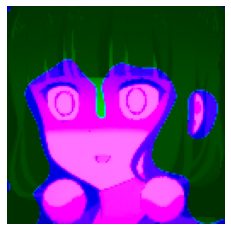

In [21]:
plot_image(r"E:\Manmade\Fotos\ANIME PICS\PicsArt_02-28-05.23.57.png")